<a href="https://colab.research.google.com/github/ProfEngel/automl/blob/main/AutoML_v1_0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
#Installation aller nötigen Python-Bibliotheken um ein AutoML auf einen Datensatz mittels Streamlit-GUI anzuwenden
%%capture
!pip install -q plotly pycaret pandas pandas_profiling streamlit_pandas_profiling imblearn lightgbm

print("Alles Fertig!")

In [31]:
# Importiere alle nötigen Bibliotheken
import pandas as pd
from google.colab import files
import os
from pycaret.datasets import get_data
from pycaret.regression import *
from pycaret.classification import *
from imblearn.over_sampling import RandomOverSampler, SMOTE
from pandas_profiling import ProfileReport
from IPython.display import display, HTML, FileLink, clear_output
import ipywidgets as widgets
import urllib.request
import lightgbm as lgb


# Überprüfen Sie, ob die Datei existiert und löschen Sie sie, falls sie existiert
if os.path.exists("dataset.csv"):
  os.remove("dataset.csv")

# Frage den Benutzer, ob er einen Datensatz hochladen möchte oder einen Datensatz aus einer Onlinequelle verwenden möchte
source = input("Möchten Sie einen Datensatz aus einer Onlinequelle verwenden oder einen Datensatz hochladen? (o/h)")

# Wenn der Benutzer einen Datensatz aus einer Onlinequelle verwenden möchte, frage nach der Quelle
if source == "o":
    online_source = input("Welche Onlinequelle möchten Sie verwenden? (UCI Machine Learning Repository/Kaggle)")
    urllib.request.urlretrieve(online_source, 'dataset.csv')
    df = pd.read_csv('dataset.csv')

# Wenn der Benutzer einen Datensatz hochladen möchte, füge eine Upload-Funktion für den Datensatz hinzu
if source == "h":
    # Wähle die Datei aus, die du hochladen möchtest
    uploaded = files.upload()
    # Ändere den Dateinamen
    for fn in uploaded.keys():
        os.rename(fn, 'dataset.csv')
    # Öffne die Datei
    df = pd.read_csv("dataset.csv")


# Erstelle den Profilbericht
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_file("output.html")

# Zeige den Bericht im Notebook an
display(HTML("output.html"))

Möchten Sie einen Datensatz aus einer Onlinequelle verwenden oder einen Datensatz hochladen? (o/h)O


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Number of variables,6
Number of observations,1309
Missing cells,263
Missing cells (%),3.3%
Duplicate rows,181
Duplicate rows (%),13.8%
Total size in memory,61.5 KiB
Average record size in memory,48.1 B
Categorical,2
Numeric,3
Boolean,1


In [ ]:
# Lassen Sie den Benutzer das Target-Merkmal auswählen
print("Verfügbare Merkmale:", df.columns.tolist())
target_column = input("Welches Merkmal soll das Target sein? ")

# Zeilen mit fehlenden Werten in der Ziel-Spalte entfernen
df = df.dropna(subset=[target_column])

# Lassen Sie den Benutzer die Merkmale auswählen, die in der Vorverarbeitung berücksichtigt werden sollen
print("\nWählen Sie die Merkmale aus, die Sie in der Vorverarbeitung berücksichtigen möchten:")
features_to_include = {}
for col in df.columns:
    if col != target_column:
        include = input(f"Möchten Sie das Merkmal '{col}' berücksichtigen? (ja/nein) ").lower() == 'ja'
        features_to_include[col] = include

# Filtern Sie die Daten basierend auf den Auswahlkriterien des Benutzers
selected_features = [col for col, include in features_to_include.items() if include]
df = df[selected_features + [target_column]]

# Zeige die ersten Zeilen des DataFrames
display(df.head())


Verfügbare Merkmale: ['Survived', 'Passenger Class', 'Name', 'Sex', 'Age', 'No of Siblings or Spouses on Board', 'No of Parents or Children on Board', 'Ticket Number', 'Passenger Fare', 'Cabin', 'Port of Embarkation', 'Life Boat']
Welches Merkmal soll das Target sein? Survived

Wählen Sie die Merkmale aus, die Sie in der Vorverarbeitung berücksichtigen möchten:
Möchten Sie das Merkmal 'Passenger Class' berücksichtigen? (ja/nein) ja
Möchten Sie das Merkmal 'Name' berücksichtigen? (ja/nein) nein
Möchten Sie das Merkmal 'Sex' berücksichtigen? (ja/nein) ja
Möchten Sie das Merkmal 'Age' berücksichtigen? (ja/nein) ja
Möchten Sie das Merkmal 'No of Siblings or Spouses on Board' berücksichtigen? (ja/nein) ja
Möchten Sie das Merkmal 'No of Parents or Children on Board' berücksichtigen? (ja/nein) ja
Möchten Sie das Merkmal 'Ticket Number' berücksichtigen? (ja/nein) nein
Möchten Sie das Merkmal 'Passenger Fare' berücksichtigen? (ja/nein) nein
Möchten Sie das Merkmal 'Cabin' berücksichtigen? (ja/n

,Passenger Class,Sex,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Survived
0,First,Female,29.0000,0,0,Yes
1,First,Male,0.9167,1,2,Yes
2,First,Female,2.0000,1,2,No
3,First,Male,30.0000,1,2,No
4,First,Female,25.0000,1,2,No


In [ ]:
# Lassen Sie den Benutzer zwischen automatischer und manueller Vorverarbeitung wählen
preprocessing_choice = input("Möchten Sie die Vorverarbeitung automatisch durchführen lassen oder selbst auswählen? (Automatisch/Manuell): ")

if preprocessing_choice.lower() == "automatisch":
    # Prüfen, ob die Anzahl der Merkmale (ohne das Zielmerkmal) größer als 10 ist
    pca = True if len(df.columns) - 1 > 10 else False
    if pca:
        pca_choice = input("Principal Component Analysis (PCA) durchführen? (ja/nein): ").lower() == 'ja'
        pca = pca_choice

    preprocessing_params = {
        'data': df,
        'target': target_column,
        'session_id': 42,
        'imputation_type': 'simple',
        'normalize': True,
        'remove_multicollinearity': True,
        'multicollinearity_threshold': 0.95,
        'polynomial_features': True,
        'feature_selection': True,
        'pca': pca
    }

else:
    # Manuelle Auswahl der Vorverarbeitungsschritte
    print("\nWählen Sie die gewünschten Vorverarbeitungsschritte:")
    imputation_type = input("Art der Imputation (simple/iterative): ")
    normalize = input("Daten normalisieren? (ja/nein): ").lower() == 'ja'
    remove_multicollinearity = input("Multikollinearität entfernen? (ja/nein): ").lower() == 'ja'
    multicollinearity_threshold = float(input("Schwellenwert für Multikollinearität (0.0 bis 1.0): "))
    polynomial_features = input("Polynomiale Merkmale hinzufügen? (ja/nein): ").lower() == 'ja'
    feature_selection = input("Merkmal-Auswahl durchführen? (ja/nein): ").lower() == 'ja'

    # Prüfen, ob die Anzahl der Merkmale (ohne das Zielmerkmal) größer als 10 ist
    pca = True if len(df.columns) - 1 > 10 else False
    if pca:
        pca_choice = input("Principal Component Analysis (PCA) durchführen? (ja/nein): ").lower() == 'ja'
        pca = pca_choice

    preprocessing_params = {
        'data': df,
        'target': target_column,
        'session_id': 42,
        'imputation_type': imputation_type,
        'normalize': normalize,
        'remove_multicollinearity': remove_multicollinearity,
        'multicollinearity_threshold': multicollinearity_threshold,
        'polynomial_features': polynomial_features,
        'feature_selection': feature_selection,
        'pca': pca
    }

Möchten Sie die Vorverarbeitung automatisch durchführen lassen oder selbst auswählen? (Automatisch/Manuell): Automatisch


Wählen Sie das Kriterium für die Modellauswahl aus ['AUC', 'Accuracy', 'Recall', 'Precision', 'F1']: AUC
AUC (Area Under the Curve)
Möchten Sie das Klassifikationstraining starten? (ja/nein): ja


,Description,Value
0,Session id,42
1,Target,Survived
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(1309, 6)"
5,Transformed data shape,"(1525, 2)"
6,Transformed train set shape,"(1132, 2)"
7,Transformed test set shape,"(393, 2)"
8,Ordinal features,1
9,Numeric features,3



Dies ist das AutoML Training


,Description,Value
0,Session id,42
1,Target,Survived
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(1309, 6)"
5,Transformed data shape,"(1525, 2)"
6,Transformed train set shape,"(1132, 2)"
7,Transformed test set shape,"(393, 2)"
8,Ordinal features,1
9,Numeric features,3


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.5491,0.5516,0.4714,0.4169,0.4409,0.0657,0.0667,0.6670
lightgbm,Light Gradient Boosting Machine,0.5522,0.5498,0.4400,0.4186,0.4269,0.0611,0.0614,0.9940
xgboost,Extreme Gradient Boosting,0.5577,0.5481,0.4286,0.4222,0.4236,0.0658,0.0660,0.4990
gbc,Gradient Boosting Classifier,0.5501,0.5477,0.4400,0.4118,0.4228,0.0559,0.0570,1.1780
rf,Random Forest Classifier,0.5587,0.5440,0.4057,0.4181,0.4101,0.0590,0.0588,1.3380
dt,Decision Tree Classifier,0.5774,0.5437,0.3686,0.4311,0.3947,0.0757,0.0763,0.5370
et,Extra Trees Classifier,0.5686,0.5374,0.3514,0.4244,0.3829,0.0563,0.0575,1.3450
lr,Logistic Regression,0.4488,0.5294,0.6714,0.3741,0.4766,-0.0158,-0.0176,1.5950
lda,Linear Discriminant Analysis,0.4488,0.5294,0.6714,0.3741,0.4766,-0.0158,-0.0176,0.4580
knn,K Neighbors Classifier,0.5589,0.5262,0.2571,0.3847,0.3035,0.0037,0.0031,1.0550


Processing:   0%|          | 0/65 [00:00<?, ?it/s]


Bestes Modell basierend auf AUC: AdaBoostClassifier(algorithm='SAMME.R', base_estimator='deprecated',
                   estimator=None, learning_rate=1.0, n_estimators=50,
                   random_state=42)

Dies ist das ML Modell


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.5491,0.5516,0.4714,0.4169,0.4409,0.0657,0.0667,0.667
lightgbm,Light Gradient Boosting Machine,0.5522,0.5498,0.4400,0.4186,0.4269,0.0611,0.0614,0.994
xgboost,Extreme Gradient Boosting,0.5577,0.5481,0.4286,0.4222,0.4236,0.0658,0.0660,0.499
gbc,Gradient Boosting Classifier,0.5501,0.5477,0.4400,0.4118,0.4228,0.0559,0.0570,1.178
rf,Random Forest Classifier,0.5587,0.5440,0.4057,0.4181,0.4101,0.0590,0.0588,1.338
dt,Decision Tree Classifier,0.5774,0.5437,0.3686,0.4311,0.3947,0.0757,0.0763,0.537
et,Extra Trees Classifier,0.5686,0.5374,0.3514,0.4244,0.3829,0.0563,0.0575,1.345
lr,Logistic Regression,0.4488,0.5294,0.6714,0.3741,0.4766,-0.0158,-0.0176,1.595
lda,Linear Discriminant Analysis,0.4488,0.5294,0.6714,0.3741,0.4766,-0.0158,-0.0176,0.458
knn,K Neighbors Classifier,0.5589,0.5262,0.2571,0.3847,0.3035,0.0037,0.0031,1.055


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


Feature Importance:


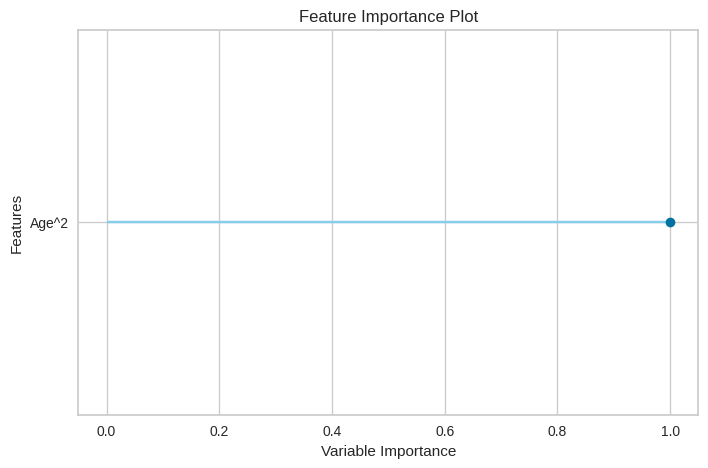

,Passenger Class,Sex,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Survived
0,First,Female,29.0000,0,0,Yes
1,First,Male,0.9167,1,2,Yes
2,First,Female,2.0000,1,2,No
3,First,Male,30.0000,1,2,No
4,First,Female,25.0000,1,2,No


,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board
count,1046.000000,1309.000000,1309.000000
mean,29.881135,0.498854,0.385027
std,14.413500,1.041658,0.865560
min,0.166700,0.000000,0.000000
25%,21.000000,0.000000,0.000000
50%,28.000000,0.000000,0.000000
75%,39.000000,1.000000,0.000000
max,80.000000,8.000000,9.000000


Transformation Pipeline and Model Successfully Saved

Das Modell wurde als 'best_model' gespeichert.


In [ ]:
# Überprüfen Sie, ob target_column definiert ist und nicht None ist
if target_column is not None:

    # Bestimmen Sie, ob das Zielmerkmal numerisch oder kategorisch ist
    if isinstance(df[target_column].iloc[0], (int, float)):
        # Wenn das Zielmerkmal kontinuierlich ist, verwende das pycaret.regression Modul

        choice = input("Möchten Sie das Regressionstraining starten? (ja/nein): ").lower()
        if choice == 'ja':
            reg = setup(**preprocessing_params)
            setup_df = pull()
            print("\nDies ist das AutoML Training")
            display(setup_df)
            best_model = compare_models()
            compare_df = pull()
            print("\nHier sind die AutoML Modelle")
            display(compare_df)
            print(f"\nBestes Modell: {best_model}")

            # Diagramme für Regression
            evaluate_model(best_model)

            # Zeige die ersten Zeilen des DataFrames
            display(df.head())

            # Statistische Zusammenfassung
            display(df.describe())

            # Modell vorhersagen
            predictions = predict_model(best_model)
            print("\nVorhersagen des Modells:")
            display(predictions)

            # Modell speichern
            save_model(best_model, 'best_model')
            print("\nDas Modell wurde als 'best_model' gespeichert.")

    else:
        # Wenn das Zielmerkmal kategorisch ist, verwende das pycaret.classification Modul

        # Prüfen Sie die Anzahl der Beispiele in jeder Klasse
        class_counts = df[target_column].value_counts()

        # Prüfen Sie die Anzahl der Beispiele in der kleinsten Klasse
        min_class_count = class_counts.min()

        # Wenn die kleinste Klasse weniger als 6 Beispiele hat (standardmäßige n_neighbors für SMOTE + 1),
        # verwenden Sie ROS, andernfalls verwenden Sie SMOTE.
        if min_class_count < 6:
            resampling_method = RandomOverSampler()
        else:
            resampling_method = SMOTE()

        preprocessing_params['fix_imbalance'] = True
        preprocessing_params['fix_imbalance_method'] = resampling_method

        # Benutzer wählt das Kriterium aus
        metrics = {
            "AUC": "AUC (Area Under the Curve)",
            "Accuracy": "Accuracy",
            "Recall": "Recall",
            "Precision": "Precision",
            "F1": "F1 Score"
        }
        sort_metric = input(f"Wählen Sie das Kriterium für die Modellauswahl aus {list(metrics.keys())}: ")
        print(metrics[sort_metric])

        choice = input("Möchten Sie das Klassifikationstraining starten? (ja/nein): ").lower()
        if choice == 'ja':
            clf = setup(**preprocessing_params)
            setup_df = pull()
            print("\nDies ist das AutoML Training")
            display(setup_df)

            best_model = compare_models(sort=sort_metric)
            print(f"\nBestes Modell basierend auf {sort_metric}: {best_model}")

            compare_df = pull()
            print("\nDies ist das ML Modell")
            display(compare_df)

            # Diagramme für Klassifikation
            evaluate_model(best_model)

            # Überprüfen, ob das Modell coef_ oder feature_importances_ Attribute hat
            if hasattr(best_model, 'coef_') or hasattr(best_model, 'feature_importances_'):
                print("\nFeature Importance:")
                plot_model(best_model, plot='feature')
            else:
                print("\nFeature Importance ist für dieses Modell nicht verfügbar.")

            # Zeige die ersten Zeilen des DataFrames
            display(df.head())

            # Statistische Zusammenfassung
            display(df.describe())

            # Modell vorhersagen
            if isinstance(best_model, list):
                if len(best_model) > 0:
                    best_model = best_model[0]
                    predictions = predict_model(best_model)
                    print("\nVorhersagen des Modells:")
                    display(predictions)
                else:
                    print("Error: Kein Modell in der Liste 'best_model' gefunden.")
                    # Beenden Sie hier, da kein Modell zum Vorhersagen vorhanden ist

            # Modell speichern
            save_model(best_model, 'best_model')
            print("\nDas Modell wurde als 'best_model' gespeichert.")


In [ ]:
# Datei-Link zum Herunterladen erstellen
link = FileLink('best_model.pkl')
display(link)

/content/best_model.pkl

In [ ]:
print("Vorhersage auf trainiertes Modell prüfen:")

# Lade das trainierte Modell
loaded_model = None
try:
    loaded_model = load_model('best_model')
except:
    print("Es wurde kein Modell gefunden. Bitte trainieren Sie zuerst ein Modell.")

# Option für den Benutzer, Daten zum Vorhersagen hochzuladen
print("\nDaten für die Vorhersage hochladen oder eingeben:")

upload_button = widgets.FileUpload(description="CSV hochladen")

def on_upload_change(change):
    clear_output(wait=True)
    predict_df = pd.read_csv(upload_button.data[-1])
    # Stellen Sie sicher, dass die Ziel-Spalte (falls vorhanden) aus dem Vorhersage-DataFrame entfernt wird
    predict_df = predict_df.drop(columns=[target_column], errors='ignore')
    predictions = predict_model(loaded_model, data=predict_df)
    print("\nVorhersageergebnisse:")
    display(predictions)

upload_button.observe(on_upload_change, names='_counter')
display(upload_button)

# Lassen Sie den Benutzer die Daten manuell eingeben, jedoch ohne die Ziel-Spalte
input_data = {}
for col in df.columns:
    # Wir überspringen die Ziel-Spalte, da wir diese vorhersagen möchten
    if col != target_column:
        value = input(f"Geben Sie einen Wert für {col} ein: ")
        input_data[col] = value

# Überprüfen, ob alle Felder ausgefüllt sind
if all(val for val in input_data.values()):
    input_df = pd.DataFrame([input_data])
    predictions = predict_model(loaded_model, data=input_df)
    print(predictions.columns)
    print("\nVorhersageergebnis:")
    print(predictions['prediction_label'].iloc[0])


Vorhersage auf trainiertes Modell prüfen:
Transformation Pipeline and Model Successfully Loaded

Daten für die Vorhersage hochladen oder eingeben:


FileUpload(value={}, description='CSV hochladen')

Geben Sie einen Wert für Passenger Class ein: Third
Geben Sie einen Wert für Sex ein: Male
Geben Sie einen Wert für Age ein: 34
Geben Sie einen Wert für No of Siblings or Spouses on Board ein: 1
Geben Sie einen Wert für No of Parents or Children on Board ein: 2


Index(['Passenger Class', 'Sex', 'Age', 'No of Siblings or Spouses on Board',
       'No of Parents or Children on Board', 'prediction_label',
       'prediction_score'],
      dtype='object')

Vorhersageergebnis:
Yes
